# 简单超分辨率 (SR) 模型 Demo
本教程演示如何使用轻量化 SRResNet 将 Fashion-MNIST 图像放大 2 倍。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class FashionSRDataset(Dataset):
    def __init__(self, train=True):
        self.base = datasets.FashionMNIST(root='./data', train=train, download=True)
        self.hr_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    
    def __len__(self):
        return len(self.base)
    
    def __getitem__(self, idx):
        hr_pil, _ = self.base[idx]
        hr_tensor = self.hr_transform(hr_pil)
        
        # 下采样生成 LR (14x14)
        lr_tensor = F.interpolate(hr_tensor.unsqueeze(0), size=(14, 14), mode='bicubic', align_corners=False).squeeze(0)
        return lr_tensor, hr_tensor

train_loader = DataLoader(FashionSRDataset(train=True), batch_size=128, shuffle=True)
test_loader = DataLoader(FashionSRDataset(train=False), batch_size=8, shuffle=False)

100%|██████████| 26.4M/26.4M [00:04<00:00, 5.75MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 101kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 1.88MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(True),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels)
        )
    def forward(self, x):
        return x + self.conv(x)

class SimpleSRModel(nn.Module):
    def __init__(self, upscale_factor=2):
        super().__init__()
        self.head = nn.Sequential(nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(True))
        self.body = nn.Sequential(*[ResidualBlock(64) for _ in range(4)])
        self.tail = nn.Sequential(
            nn.Conv2d(64, 64 * (upscale_factor**2), 3, padding=1),
            nn.PixelShuffle(upscale_factor),
            nn.Conv2d(64, 1, 3, padding=1)
        )

    def forward(self, x):
        x = self.head(x)
        x = self.body(x)
        return self.tail(x)


In [4]:
model = SimpleSRModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
epochs = 5 # Demo演示，5个epoch即可看到效果
model.train()

for epoch in range(epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    epoch_loss = 0
    for lr, hr in pbar:
        lr, hr = lr.to(device), hr.to(device)
        
        sr = model(lr)
        loss = criterion(sr, hr)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

Epoch 5/5: 100%|██████████| 469/469 [00:16<00:00, 27.61it/s, loss=0.0184]


In [6]:
def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    return 10 * torch.log10(1 / mse)

model.eval()
lr_imgs, hr_imgs = next(iter(test_loader))
with torch.no_grad():
    sr_imgs = model(lr_imgs.to(device)).cpu()

## 4. 可视化结果对比
我们对比四种图像：
1. **LR**: 输入的低分辨率图 (14x14)
2. **Bicubic**: 传统的双三次插值放大 (基准)
3. **SR Model**: 我们的模型输出
4. **GT**: 真实的高分辨率图 (28x28)

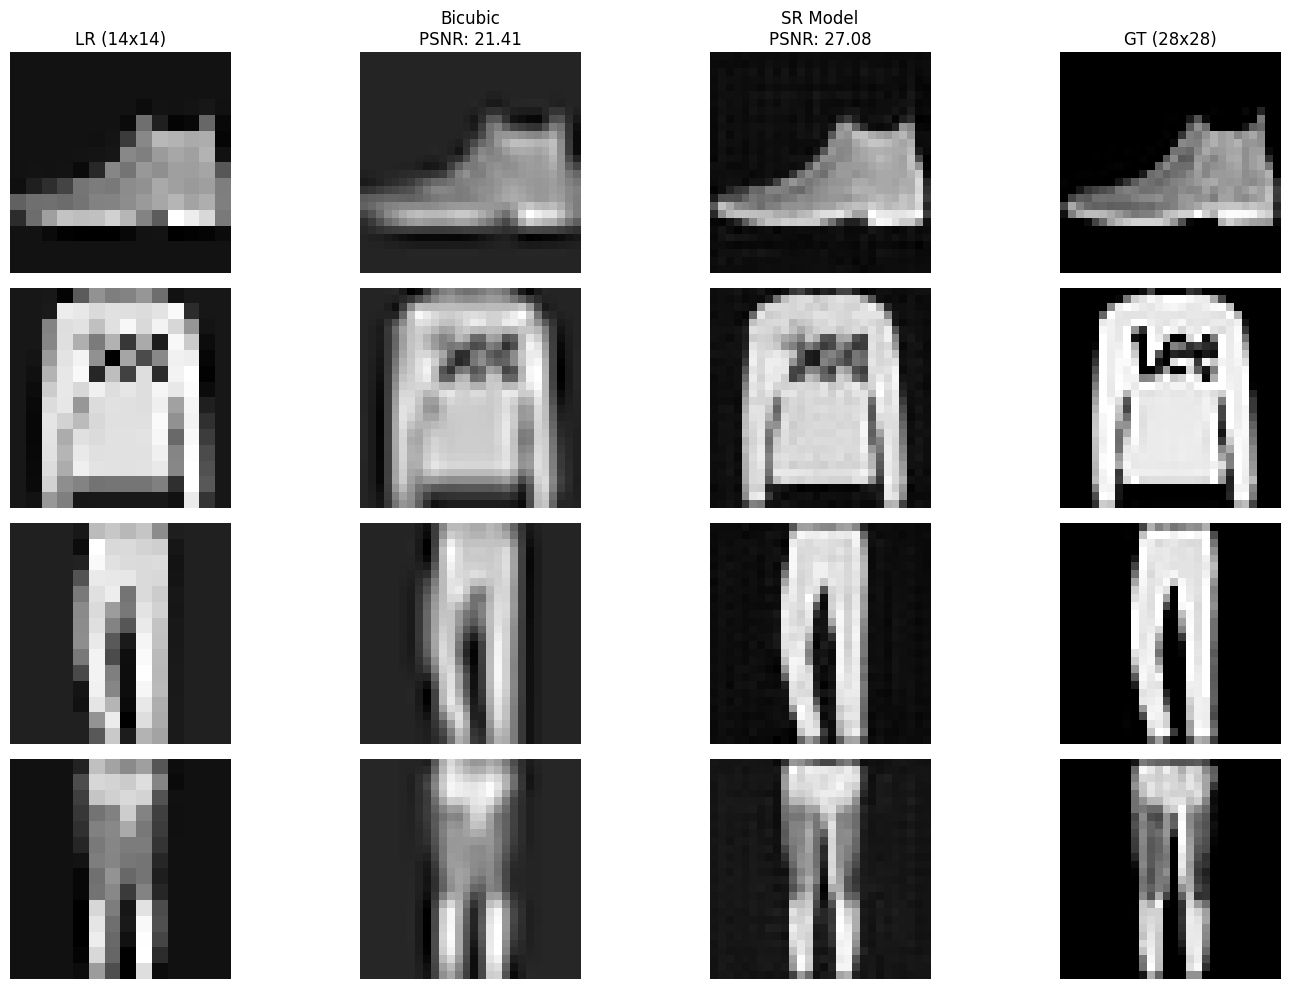

In [7]:
plt.figure(figsize=(15, 10))
for i in range(4): # 展示4组对比
    # 反归一化
    def denorm(x): return (x + 1) / 2
    
    # 获取图像
    lr = denorm(lr_imgs[i][0])
    bc = denorm(F.interpolate(lr_imgs[i:i+1], size=(28, 28), mode='bicubic')).squeeze()
    sr = denorm(sr_imgs[i][0])
    gt = denorm(hr_imgs[i][0])
    
    # 计算 PSNR
    psnr_bc = calculate_psnr(bc, gt)
    psnr_sr = calculate_psnr(sr, gt)
    
    # 画图
    titles = [f"LR (14x14)", f"Bicubic\nPSNR: {psnr_bc:.2f}", f"SR Model\nPSNR: {psnr_sr:.2f}", "GT (28x28)"]
    imgs = [lr, bc, sr, gt]
    
    for j in range(4):
        plt.subplot(4, 4, i * 4 + j + 1)
        plt.imshow(imgs[j], cmap='gray')
        if i == 0: plt.title(titles[j])
        plt.axis('off')

plt.tight_layout()
plt.show()